Import required packages

In [92]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy import distance
import folium
import requests
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Import Foursquare credentials from json file created to preserve secrecy and store in global variables CLIENT_ID and CLIENT_SECRET

In [2]:
import json
globals().update(json.loads(open("foursquareCredentials.json", "r") .read()))
VERSION = '20181124' # Foursquare API version

Get longitude and latitude of location

In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Rumbach Sebestyén u., Budapest, 1075 Hungary")
lat = location.latitude
long = location.longitude

Define function degreeLen which for a given lat and long returns the length of a degree of lat and long in km

In [4]:
def degreeLen(lat, long):
    """Returns the lengths of a single degree of latitude and longitude in km for a given latitude and longitude
    """
    # get length of 1 degree at current latidude and logitude
    latDegree = distance.distance((lat - 0.5, long), (lat + 0.5, long)).km
    longDegree = distance.distance((lat, long - 0.5), (lat, long + 0.5)).km
    return latDegree, longDegree
degreeLen(lat, long)

(111.18052869040775, 75.34729533841742)

Define function grid that returns the set of grid points within a circle around location.  Grid points are a distance tick apart.

In [5]:
def grid(lat, long, radius, tick):
    """Returns a set whose elements are a grid of points within a circle around a location
    :param lat: latitude of centre of grid
    :param long: longitude of centre of grid
    :param radius: radius of grid in km
    :param tick: distance between points in grid in km
    """
    # get length of 1 degree at current latidude and logitude
    latDegree, longDegree = degreeLen(lat, long)
    
    # get length of 1 tick in degrees
    latTick = tick / latDegree
    longTick = tick / longDegree
    
    # get coordinates of point which is one radius to the South and West of (lat, long)
    bottomLeft = (lat - radius / latDegree, long - radius / longDegree)
    
    # get tick points along axis
    gridLats = np.arange(2 * radius / tick + 1) * latTick + bottomLeft[0]
    gridLongs = np.arange(2 * radius / tick + 1) * longTick + bottomLeft[1]
    
    # initialise set grid
    grid = set()
    
    # populate set grid
    for lt in gridLats:
        [grid.add((lt, lg)) for lg in gridLongs if distance.distance((lat, long), (lt, lg)).km <= radius]
        
    return grid

Check grid function is working using Folium

In [6]:
g = grid(lat, long, 2, 0.2)
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in g:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=0.5).add_to(map_grid)
       
map_grid

Define function for pulling list of nearby venues, with optional filter on category Id

In [7]:
def getNearbyVenues(lat, long, radius, categoryId = ''):
    url = ('https://api.foursquare.com/v2/venues/search?' +
            '&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION) +
            '&intent=browse&ll={},{}&radius={}&categoryId={}'.format(lat, long, radius, categoryId))
    
    venues = requests.get(url).json()['response']['venues']
    venues_list=[]
    
    for v in venues:
        if len(v['categories']) > 0:
            venues_list.append([v['id'], v['name'], v['location']['distance'], v['categories'][0]['name']])
        else:
            venues_list.append([v['id'], v['name'], v['location']['distance'], 'None'])
    
    return(venues_list)

Check function getNearbyVenues is working

In [8]:
categoryId = '4bf58dd8d48988d16d941735'
radius = 200
getNearbyVenues(lat, long, radius, categoryId)

[['510c25ede4b0a3ee4308e94a', 'Központ', 188, 'Café'],
 ['4c9ce18c542b224bbaade49f', 'Drum Cafe', 100, 'Café'],
 ['52054dd511d2778ebd4f1cf3', 'Blue Bird Cafe', 171, 'Café'],
 ['514d9e95e4b01bb2769654a3', 'Solinfo', 67, 'Café'],
 ['5b9a6c1d1ffe97002c3349c7', 'Fresh Corner Downtown', 187, 'Café'],
 ['4c8e63f5a8de224be0182701', 'Café Vian', 182, 'French Restaurant'],
 ['54535798498ef0cd9c592e6e', 'Blue Bird Roastery', 137, 'Café'],
 ['4b804281f964a520d36130e3', 'Spinoza Café', 87, 'Restaurant'],
 ['4b99441cf964a520be6e35e3', 'Printa Café', 111, 'Art Gallery'],
 ['5152e6f0e4b02b6799b2ef78', 'Tom Dixon Cafè & Showroom', 62, 'Café'],
 ['57c41471498e814e459823ff', 'Blue Bird Cafe', 130, 'Café'],
 ['5bda0a2bb3c961002badd1c6', 'Kárpit Café', 128, 'Café'],
 ['582332825c3b582b1122a742', 'Cabbage Coffee', 147, 'Café'],
 ['4c20cfe93573c9b602ea3515', 'Café Zenit', 148, 'Pub'],
 ['4e5e5c65a809fd79d2976f26', 'Bench Café', 159, 'Café'],
 ['4d78b13e9e57a0932180c72b',
  "Osteria dell' Oca Italian Restaur

Define function targetDensity which outputs a measure the density of a list of venues within a specific radius of a location.
The density measure has the property of being larger the more venues there are in the list and the closer they are.
So for each venue we subtract the distance from the radius so that a venue in the centre of the circle adds the radius distance to the density measure while a venue on the edge of the circle adds 0 to the density measure.

In [9]:
def targetDensity(venues, radius):
    distances = []
    [distances.append(radius - v[2]) for v in venues if v[2] <= radius]
    return np.sum(np.asarray(distances))
targetDensity(getNearbyVenues(lat, long, radius, categoryId), radius)

1635

In [10]:
# Check if density for empty list of venues = 0
targetDensity([], radius)

0.0

In [11]:
targets = []
ids = set()
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, radius, categoryId)
    density = targetDensity(venues, radius)
    targets.append((lt, lg, density))
    for (v_id, name, distance, category) in venues:
        ids.add(v_id)

(47.498829676137355, 19.078470527130836)
(47.50422630454943, 19.062544275304408)
(47.49343304772528, 19.03600052226036)
(47.4970308, 19.067853025913216)
(47.50242742841207, 19.03865489756476)
(47.50242742841207, 19.065198650608814)
(47.491634171587926, 19.041309272869167)
(47.4970308, 19.057235524695596)
(47.4970308, 19.083779277739648)
(47.506025180686784, 19.054581149391193)
(47.511421809098856, 19.070507401217622)
(47.50242742841207, 19.0598899)
(47.50782405682414, 19.043963648173573)
(47.51322068523621, 19.065198650608814)
(47.48983529545056, 19.083779277739648)
(47.498829676137355, 19.04927239878238)
(47.50782405682414, 19.04661802347798)
(47.51322068523621, 19.062544275304408)
(47.47904203862642, 19.0598899)
(47.491634171587926, 19.067853025913216)
(47.49343304772528, 19.03865489756476)
(47.49343304772528, 19.065198650608814)
(47.50242742841207, 19.03600052226036)
(47.506025180686784, 19.081124902435242)
(47.50782405682414, 19.051926774086787)
(47.49523192386264, 19.0705074012176

(47.50062855227471, 19.083779277739648)
(47.48443866703849, 19.051926774086787)
(47.491634171587926, 19.073161776522028)
(47.4970308, 19.043963648173573)
(47.50422630454943, 19.03600052226036)
(47.506025180686784, 19.0598899)
(47.50782405682414, 19.073161776522028)
(47.488036419313204, 19.041309272869167)
(47.49523192386264, 19.04927239878238)
(47.50062855227471, 19.078470527130836)
(47.5096229329615, 19.062544275304408)
(47.511421809098856, 19.04661802347798)
(47.48263979090113, 19.0598899)
(47.488036419313204, 19.07581615182643)
(47.49523192386264, 19.067853025913216)
(47.498829676137355, 19.03600052226036)
(47.50422630454943, 19.051926774086787)
(47.48443866703849, 19.078470527130836)
(47.48983529545056, 19.04927239878238)
(47.498829676137355, 19.057235524695596)
(47.498829676137355, 19.083779277739648)
(47.50422630454943, 19.054581149391193)
(47.51322068523621, 19.070507401217622)
(47.48983529545056, 19.065198650608814)
(47.48983529545056, 19.03865489756476)
(47.49523192386264, 19.

In [12]:
targetsDf = pd.DataFrame(targets)
targetsDf.columns = ['Latitude', 'Longitude', 'Density']
targetsDf.set_index(['Latitude', 'Longitude'], inplace=True)
targetsDf.sort_index(inplace=True)
targetsDf

Density
Latitude  Longitude         
47.479042 19.059890      0.0
47.480841 19.049272     59.0
          19.051927    800.0
          19.054581    499.0
          19.057236     55.0
          19.059890      0.0
          19.062544      0.0
          19.065199    325.0
          19.067853    298.0
          19.070507    937.0
47.482640 19.046618      0.0
          19.049272      0.0
          19.051927    693.0
          19.054581    612.0
          19.057236     20.0
          19.059890    112.0
          19.062544     25.0
          19.065199    109.0
          19.067853    433.0
          19.070507    768.0
          19.073162    571.0
47.484439 19.041309      0.0
          19.043964      0.0
          19.046618      0.0
          19.049272      0.0
          19.051927     74.0
          19.054581     83.0
          19.057236      0.0
          19.059890    969.0
          19.062544    594.0
...                      ...
47.509623 19.059890    223.0
          19.062544    366.0
          19.065199    192.0
          19.067853    555.0
          19.070507    192.0
          19.073162     23.0
          19.075816      0.0
          19.078471     48.0
47.511422 19.043964      0.0
          19.046618    189.0
          19.049272    288.0
          19.051927    868.0
          19.054581    453.0
          19.057236   1155.0
          19.059890    375.0
          19.062544    399.0
          19.065199    109.0
          19.067853    253.0
          19.070507    126.0
          19.073162    260.0
          19.075816     30.0
47.513221 19.049272    769.0
          19.051927    569.0
          19.054581    432.0
          19.057236   2182.0
          19.059890   2296.0
          19.062544     39.0
          19.065199      0.0
          19.067853      0.0
          19.070507      9.0

[310 rows x 1 columns]

In [13]:
ids

{'4b405e24f964a520e1b725e3',
 '4b45eee3f964a520821226e3',
 '4b4fb933f964a520a41227e3',
 '4b52bdaef964a520328727e3',
 '4b559b58f964a520d2e827e3',
 '4b561c01f964a520d00028e3',
 '4b66f242f964a520a7312be3',
 '4b68a5d2f964a520be842be3',
 '4b69bf00f964a52085b12be3',
 '4b69c896f964a520f8b32be3',
 '4b6af49df964a520cae82be3',
 '4b76ff93f964a520e7722ee3',
 '4b782fcbf964a520b8ba2ee3',
 '4b7e8a1af964a520bcf12fe3',
 '4b7f05e8f964a520051130e3',
 '4b804281f964a520d36130e3',
 '4b82aa9af964a52052dd30e3',
 '4b83b33cf964a520670d31e3',
 '4b85b1e3f964a5205f6d31e3',
 '4b99441cf964a520be6e35e3',
 '4b9b6c79f964a520730636e3',
 '4b9fa2e8f964a520803037e3',
 '4ba15a89f964a5206baf37e3',
 '4ba1e53ff964a520efd037e3',
 '4ba4b1b7f964a520e0ac38e3',
 '4ba644eaf964a520ec4039e3',
 '4ba74045f964a520f38739e3',
 '4bab8db2f964a5200ab33ae3',
 '4bb2507d14cfd13a47c514ab',
 '4bb354612397b713b1f137b3',
 '4bb4d546bc82a593ade83e72',
 '4bbadceeb35776b08763cb01',
 '4bbf46e898f49521ef56d263',
 '4bbf610a006dc9b6377afc3f',
 '4bbf8d8aabf4

In [18]:
otherVenues = []
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, radius)
    for (v_id, name, distance, category) in venues:
        if not (v_id in ids) and category != 'None':
            otherVenues.append((lt, lg, v_id, name, distance, category))

(47.498829676137355, 19.078470527130836)
(47.50422630454943, 19.062544275304408)
(47.49343304772528, 19.03600052226036)
(47.4970308, 19.067853025913216)
(47.50242742841207, 19.03865489756476)
(47.50242742841207, 19.065198650608814)
(47.491634171587926, 19.041309272869167)
(47.4970308, 19.057235524695596)
(47.4970308, 19.083779277739648)
(47.506025180686784, 19.054581149391193)
(47.511421809098856, 19.070507401217622)
(47.50242742841207, 19.0598899)
(47.50782405682414, 19.043963648173573)
(47.51322068523621, 19.065198650608814)
(47.48983529545056, 19.083779277739648)
(47.498829676137355, 19.04927239878238)
(47.50782405682414, 19.04661802347798)
(47.51322068523621, 19.062544275304408)
(47.47904203862642, 19.0598899)
(47.491634171587926, 19.067853025913216)
(47.49343304772528, 19.03865489756476)
(47.49343304772528, 19.065198650608814)
(47.50242742841207, 19.03600052226036)
(47.506025180686784, 19.081124902435242)
(47.50782405682414, 19.051926774086787)
(47.49523192386264, 19.0705074012176

(47.50062855227471, 19.083779277739648)
(47.48443866703849, 19.051926774086787)
(47.491634171587926, 19.073161776522028)
(47.4970308, 19.043963648173573)
(47.50422630454943, 19.03600052226036)
(47.506025180686784, 19.0598899)
(47.50782405682414, 19.073161776522028)
(47.488036419313204, 19.041309272869167)
(47.49523192386264, 19.04927239878238)
(47.50062855227471, 19.078470527130836)
(47.5096229329615, 19.062544275304408)
(47.511421809098856, 19.04661802347798)
(47.48263979090113, 19.0598899)
(47.488036419313204, 19.07581615182643)
(47.49523192386264, 19.067853025913216)
(47.498829676137355, 19.03600052226036)
(47.50422630454943, 19.051926774086787)
(47.48443866703849, 19.078470527130836)
(47.48983529545056, 19.04927239878238)
(47.498829676137355, 19.057235524695596)
(47.498829676137355, 19.083779277739648)
(47.50422630454943, 19.054581149391193)
(47.51322068523621, 19.070507401217622)
(47.48983529545056, 19.065198650608814)
(47.48983529545056, 19.03865489756476)
(47.49523192386264, 19.

In [16]:
len(allVenues)

8927

In [17]:
len(ids)

648

In [19]:
len(otherVenues)

8665

In [25]:
otherVenuesDf = pd.DataFrame(otherVenues)
otherVenuesDf.columns = ['Latitude', 'Longitude', 'VenueID', 'Name', 'Distance', 'Category']
otherVenuesDf.set_index(['Latitude', 'Longitude'], inplace=True)
otherVenuesDf.sort_index(inplace=True)
otherVenuesDf

VenueID  \
Latitude  Longitude                             
47.479042 19.059890  4ba8e306f964a5202cf739e3   
          19.059890  4ba3b92bf964a5206c5838e3   
          19.059890  4f059727d3e321b78f7a6655   
          19.059890  511a3517e4b0d096c320ede9   
          19.059890  5669bf30498e50a39729c6de   
          19.059890  4e08adaaa809495e61a017a8   
          19.059890  4d09d878ddb8f04dfb9e30aa   
          19.059890  4fcef568e4b0b4dd488d5295   
          19.059890  51b86e3e498e2a70c2f4930e   
          19.059890  4ba8e9eff964a52097f939e3   
          19.059890  526513c8498e22282fd037a2   
          19.059890  5240014f11d29e0419c1077b   
          19.059890  4ea694f07ee5bebc94b27a20   
          19.059890  4ba8ebeaf964a52058fa39e3   
          19.059890  52fcbf52498e5a3089ed1df9   
          19.059890  582ed5e00b5656378a87d099   
          19.059890  507575ebe4b01d2c3d4b03a3   
          19.059890  508bf7b1e4b0a1c8476fff2d   
          19.059890  545b5c76498ee6fdb442ad29   
          19.059890  506182fae4b008c57d902a7c   
          19.059890  4f44c1c8e4b0f1d45d1efbcb   
          19.059890  4e4976c31fc7a73d0db38fcd   
          19.059890  4ca8fb87965c9c74a1eac9fa   
          19.059890  551cea77498e7ada62c89a0b   
          19.059890  5703ab49498e54b9c6689c1f   
          19.059890  576ce61c498e72c8c4d7935e   
          19.059890  58739e2f45c3ed099825fd76   
          19.059890  4f38e491e4b0d408a5eda9e2   
          19.059890  53a038a7498e08a9de3e2fad   
          19.059890  4ba8e0a1f964a5204bf639e3   
...                                       ...   
47.513221 19.070507  4d2daf8baa5c6ea8cd39af04   
          19.070507  4c8a42021eafb1f7d6787835   
          19.070507  4f8d8f77e4b07efba19ac369   
          19.070507  56b8eaac498e84344c13e44f   
          19.070507  5b7562651953f3002c045a98   
          19.070507  59d4bf8a67af3a1571dbab7d   
          19.070507  4ea04dca722e575b9ed40d86   
          19.070507  53b80580498e041871fa8844   
          19.070507  593d1b82088158548cf02b4f   
          19.070507  4e6a1d83922ec475e8907c12   
          19.070507  53442630498eb143ea755472   
          19.070507  56dc5c4d498e9bfed83e5a9a   
          19.070507  564f4887498e9cd06b7e9ad6   
          19.070507  4e6efb1f8998fd5c566ace68   
          19.070507  4ce02f7570bba1cd98e06ac4   
          19.070507  4e8eb3c9b8f7c08295aa22b8   
          19.070507  4e9717dd93ad7ae7cd49e22d   
          19.070507  4eb39d5293ad23656f5c6875   
          19.070507  5898a0cf1e1de501d968c097   
          19.070507  536620ec498e7186ef609364   
          19.070507  4f9cfaf2e4b060916940d353   
          19.070507  4d090fc184ec224b7cfd2c62   
          19.070507  59b6e8493c858d7f3bf6f83f   
          19.070507  519e3ce4498ec1672c4049dc   
          19.070507  576fc39c498e9e879e5071e3   
          19.070507  5b9cdd794a1cc00039904b61   
          19.070507  4de241e9ae60e7f3abea80d8   
          19.070507  590845f29e0d541198c42483   
          19.070507  51c5e112498e71cc06b3e27e   
          19.070507  59e59b8f2105c368b3f74975   

                                                                  Name  \
Latitude  Longitude                                                      
47.479042 19.059890                                       BME R épület   
          19.059890                                         Petőfi híd   
          19.059890                    BME Központi Tanulmányi Hivatal   
          19.059890                                            BME R4D   
          19.059890                   Műegyetemi Református Lelkészség   
          19.059890                   Valdemar és Nina Langlet rakpart   
          19.059890                    BME Nukleáris Technikai Intézet   
          19.059890                                           BME R108   
          19.059890                     BME Kognitív Tudományi Tanszék   
          19.059890                                       BME T épület   
          19.059890                   Hardbodyhang Street Work

In [29]:
otherVenuesDf.groupby(['Latitude', 'Longitude', 'Category'])['Distance'].sum().to_frame()

Distance
Latitude  Longitude Category                                 
47.479042 19.059890 Athletics & Sports                    139
                    Bank                                  190
                    Bridge                                237
                    Buffet                                 52
                    College Academic Building             279
                    College Administrative Building        36
                    College Arts Building                 204
                    College Classroom                     522
                    College Engineering Building          145
                    College Lab                           348
                    College Science Building              269
                    Doctor's Office                       135
                    General College & University          142
                    Gym / Fitness Center                  178
                    Prayer Room                            26
                    Road                                   21
                    Student Center                         82
                    University                            173
47.480841 19.049272 Arcade                                 42
                    Art Gallery                           269
                    Athletics & Sports                     77
                    Basketball Court                      125
                    Bike Shop                             240
                    Bookstore                              98
                    College Administrative Building        64
                    College Auditorium                     59
                    College Cafeteria                     146
                    College Gym                            65
                    College Library                        44
                    College Technology Building            86
...                                                       ...
47.513221 19.067853 Tailor Shop                            58
                    Thrift / Vintage Store                 48
          19.070507 Art Gallery                            64
                    Auditorium                             36
                    Bakery                                146
                    Beer Garden                            87
                    Betting Shop                           68
                    Church                                117
                    College Arts Building                  75
                    Convenience Store                      82
                    Deli / Bodega                         127
                    Department Store                       64
                    Flower Shop                           113
                    Fruit & Vegetable Store               175
                    Garden                                 70
                    Grocery Store                         118
                    Gym / Fitness Center                 1424
                    Health & Beauty Service                92
                    Historic Site                         174
                    Ice Cream Shop                        165
                    Liquor Store                           88
                    Office                                191
                    Pastry Shop                            93
                    Perfume Shop                          104
                    Pool                                  186
                    Professional & Other Places           102
                    Road                                  295
                    Smoke Shop                            161
                    Spiritual Center                      356
                    Whisky Bar                            158

[7098 rows x 1 columns]

In [40]:
features = pd.pivot_table(otherVenuesDf,index=['Latitude', 'Longitude'],values='Distance',
                          columns='Category',aggfunc=[np.sum],fill_value=0)['sum']

In [41]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 310 entries, (47.47904203862642, 19.0598899) to (47.51322068523621, 19.070507401217622)
Columns: 497 entries, ATM to Zoo Exhibit
dtypes: int64(497)
memory usage: 1.2 MB


In [42]:
features

Category             ATM  Accessories Store  Adult Boutique  \
Latitude  Longitude                                           
47.479042 19.059890    0                  0               0   
47.480841 19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   
47.482640 19.046618    0                  0               0   
          19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0              68   
          19.070507    0                  0               0   
          19.073162    0                  0               0   
47.484439 19.041309    0                  0               0   
          19.043964    0                  0               0   
          19.046618    0                  0               0   
          19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
...                  ...                ...             ...   
47.509623 19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                 25               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   
          19.073162    0                  0               0   
          19.075816    0                  0               0   
          19.078471    0                  0               0   
47.511422 19.043964    0                  0               0   
          19.046618    0                  0               0   
          19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   
          19.073162    0                  0               0   
          19.075816    0                  0               0   
47.513221 19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   

Category             Advertisi

In [43]:
row_x1 = ['a1','b1','c1']
row_x2 = ['a2','b2','c2']
row_x3 = ['a3','b3','c3']
row_x4 = ['a4','b4','c4']
index_arrays = [np.array(['first', 'first', 'second', 'second']), np.array(['one','two','one','two'])]
df1 = pd.DataFrame([row_x1,row_x2,row_x3,row_x4], columns=list('ABC'), index=index_arrays)
print(df1)

             A   B   C
first  one  a1  b1  c1
       two  a2  b2  c2
second one  a3  b3  c3
       two  a4  b4  c4


In [46]:
row_x1 = [3]
row_x2 = [8]
row_x3 = [89]
row_x4 = [1]
index_arrays = [np.array(['first', 'first', 'second', 'third']), np.array(['one','two','two', 'seven'])]
df2 = pd.DataFrame([row_x1,row_x2,row_x3, row_x3], columns=['D'], index=index_arrays)
print(df2)

               D
first  one     3
       two     8
second two    89
third  seven  89


In [68]:
features = features.join(targetsDf).fillna(0).reset_index()

In [72]:
X = features.drop(['Latitude', 'Longitude', 'Density'], axis=1)
y = features['Density']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [89]:
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
reg_all.score(X_test, y_test)

-33.663960741405056

In [90]:
y_pred.astype(int)

array([   671,    593,    855,    924,   -681,    767,    515,   1194,
          102,   1374,    238,    632,    386,   -130,    740,    671,
          863,   1033,    387,    433,   -254,   -860,   -841,    448,
          742,    396,    905,    887,   -625,    609,   -503,    564,
          593,    330,    145,    304,    248,    259,     45,    851,
          -17,  -2056,    266,   1683,   -885,   -215,    401,    -64,
       -18477,   1501,   1095,   1066,    775,   -286,    882,    903,
          654,    613,    677,   1201,   1601,    686])

In [94]:
np.maximum(y_pred.astype(int), 0)

array([ 671,  593,  855,  924,    0,  767,  515, 1194,  102, 1374,  238,
        632,  386,    0,  740,  671,  863, 1033,  387,  433,    0,    0,
          0,  448,  742,  396,  905,  887,    0,  609,    0,  564,  593,
        330,  145,  304,  248,  259,   45,  851,    0,    0,  266, 1683,
          0,    0,  401,    0,    0, 1501, 1095, 1066,  775,    0,  882,
        903,  654,  613,  677, 1201, 1601,  686])

In [91]:
y_test.values

array([ 189.,  937.,  312., 1493.,   74.,  287.,  106.,  441.,  862.,
        427., 1062.,  370.,  109.,    0.,   23.,  288.,    0.,  875.,
        519.,  665.,   94.,    0.,  118.,  829., 1339.,  966., 1167.,
        836.,  886.,  681.,   26.,  499.,   76.,  311.,  632.,  105.,
       1078.,  109.,   40.,  301.,  293.,    0.,   81.,  380.,  126.,
        127.,  679.,  325.,   48.,  881.,  514.,  389.,  756.,  249.,
          0., 1378.,  569.,  239.,  550., 1604.,  353.,  165.])

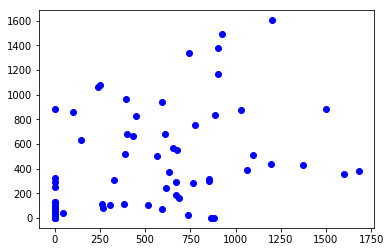

In [95]:
plt.scatter(np.maximum(y_pred.astype(int), 0), y_test, color='blue')
plt.show()

In [96]:
y_pred = reg_all.predict(X)

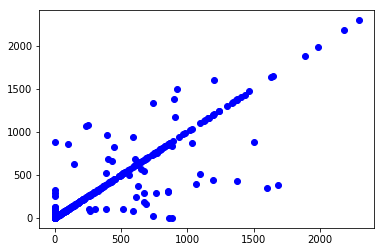

In [97]:
plt.scatter(np.maximum(y_pred.astype(int), 0), y, color='blue')
plt.show()

In [98]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)

-8.143266078860522

In [100]:
lasso_pred.astype(int)

array([  684,   505,  1247,   619,   -13,   815,   623,   642,   328,
         659,   767,   509,   330,   -66,   525,   506,   749,   585,
         485,   574,   342,  -491,  -215,   663,   923,   285,   586,
         557,  -261,   660,  -378,   444,   243,   293,   366,   735,
         248,   504,   547,   157,  -212,  -875,   614,   405,  -233,
         507,   369,  -419, -8879,  1333,   836,   919,   480,   302,
        1802,   636,   404,   636,   484,   735,   477,  1210])

In [101]:
np.maximum(lasso_pred.astype(int), 0)

array([ 684,  505, 1247,  619,    0,  815,  623,  642,  328,  659,  767,
        509,  330,    0,  525,  506,  749,  585,  485,  574,  342,    0,
          0,  663,  923,  285,  586,  557,    0,  660,    0,  444,  243,
        293,  366,  735,  248,  504,  547,  157,    0,    0,  614,  405,
          0,  507,  369,    0,    0, 1333,  836,  919,  480,  302, 1802,
        636,  404,  636,  484,  735,  477, 1210])

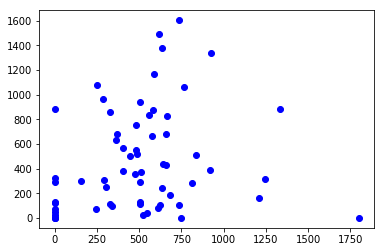

In [102]:
plt.scatter(np.maximum(lasso_pred.astype(int), 0), y_test, color='blue')
plt.show()

In [103]:
lasso_pred_all = lasso.predict(X)

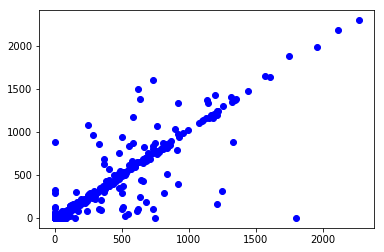

In [104]:
plt.scatter(np.maximum(lasso_pred_all.astype(int), 0), y, color='blue')
plt.show()

In [105]:
y

0         0.0
1        59.0
2       800.0
3       499.0
4        55.0
5         0.0
6         0.0
7       325.0
8       298.0
9       937.0
10        0.0
11        0.0
12      693.0
13      612.0
14       20.0
15      112.0
16       25.0
17      109.0
18      433.0
19      768.0
20      571.0
21        0.0
22        0.0
23        0.0
24        0.0
25       74.0
26       83.0
27        0.0
28      969.0
29      594.0
        ...  
280     223.0
281     366.0
282     192.0
283     555.0
284     192.0
285      23.0
286       0.0
287      48.0
288       0.0
289     189.0
290     288.0
291     868.0
292     453.0
293    1155.0
294     375.0
295     399.0
296     109.0
297     253.0
298     126.0
299     260.0
300      30.0
301     769.0
302     569.0
303     432.0
304    2182.0
305    2296.0
306      39.0
307       0.0
308       0.0
309       9.0
Name: Density, Length: 310, dtype: float64

In [106]:
np.maximum(lasso_pred_all.astype(int), 0)

array([  11,   83,  731,  444,   51,  749,   12,    0,  369,  505,    9,
        149,  676,  555,   44,  141,   24,  504,  408,  759,  570,    0,
         80,    5,    0,    0,   58,   88,  922,  596,  248,  167,  473,
        557,  382,    4,   18,   28,    0,   20,    9,   60,    0,  365,
       1170,  248,  659,  525, 1319, 1216,   35,   28,    0,   82,    4,
         47,  179, 1247, 1197,  661,  619,  491,  247,  815,  283,  110,
         46,   18,  227,  169,   71,   72,   38,  342,  231,  767,  923,
       1333,  911,  694,  714,  476,  243,  132,  302,   14,   94,   46,
          0,    0,  219,  119,  623,  366, 1189,  685,  735,  404,  372,
        280,  203,  735,  190,   51,    0,    0,   14,    0,    0,  168,
          0,  132, 1751,  586,  836,  957,  338,  184,  228,  157,  373,
        173,   34,  111,    8,  365,  202,  193,  146,   46,  810, 1255,
        507,  734, 1320,  835,  446,    0,  294,    0,   80,    0,  127,
        105,   62,  480,  615,   76,  174, 1208, 11